<a href="https://colab.research.google.com/github/MammadovN/Machine_Learning/blob/main/projects/03_deep_learning/sequence_modelling/sentiment_analysis_rnn/sentiment_analysis_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


# Device check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
!pip install -U nltk
import nltk
nltk.download('punkt', quiet=False)
nltk.download('stopwords', quiet=False)
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Text preprocessing functions
def preprocess_text(text):
    """Prepare text for an RNN: convert to lowercase, remove punctuation, apply stemming."""
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation and digits
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Tokenise
    tokens = word_tokenize(text)

    # Remove stop-words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Apply stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return tokens


def build_vocab(texts, max_words: int = 10_000):
    """Build a vocabulary from all texts."""
    all_words = []
    for text in texts:
        all_words.extend(text)

    word_counter = Counter(all_words)
    vocab = {
        '<PAD>': 0,  # Special token for padding
        '<UNK>': 1,  # Special token for unknown words
    }

    # Add the most frequent words to the vocabulary
    for word, _ in word_counter.most_common(max_words - 2):
        vocab[word] = len(vocab)

    return vocab


def encode_text(text, vocab, max_length: int = 100):
    """Convert a token list into a sequence of integers."""
    encoded = [vocab.get(word, vocab['<UNK>']) for word in text]

    # Pad or truncate to a fixed length
    if len(encoded) < max_length:
        encoded += [vocab['<PAD>']] * (max_length - len(encoded))
    else:
        encoded = encoded[:max_length]

    return encoded


In [ ]:
# Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_length: int = 100):
        """
        Args
        ----
        texts : list[list[str]]
            Pre-tokenised texts.
        labels : list[int] | list[float]
            Ground-truth sentiment labels.
        vocab : dict[str, int]
            Word-to-index mapping.
        max_length : int, optional
            Sequence length to pad/truncate to.
        """
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self) -> int:
        """Return dataset size."""
        return len(self.texts)

    def __getitem__(self, idx: int):
        """Return one (encoded_text, label) pair as tensors."""
        encoded_text = encode_text(self.texts[idx], self.vocab, self.max_length)
        return (
            torch.tensor(encoded_text, dtype=torch.long),
            torch.tensor(self.labels[idx], dtype=torch.float),
        )


In [ ]:
# RNN Model
class SentimentRNN(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        output_dim: int,
        n_layers: int,
        bidirectional: bool,
        dropout: float,
    ):
        super(SentimentRNN, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layer
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True,
        )

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer
        # If using a bidirectional LSTM, multiply hidden_dim by 2
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

    def forward(self, text):
        # text shape: [batch size, seq length]

        # Pass through the embedding layer
        embedded = self.embedding(text)
        # embedded shape: [batch size, seq length, embedding dim]

        # Pass through the LSTM layer
        output, (hidden, cell) = self.lstm(embedded)
        # output shape : [batch size, seq length, hidden dim * num directions]
        # hidden shape : [num layers * num directions, batch size, hidden dim]

        if self.lstm.bidirectional:
            # If bidirectional, concatenate the final forward & backward hidden states
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            hidden = hidden[-1, :, :]
        # hidden shape: [batch size, hidden dim * num directions]

        # Apply dropout
        hidden = self.dropout(hidden)

        # Pass through the output layer
        return self.fc(hidden)


In [ ]:
# Model-training function
def train_model(model,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                n_epochs: int = 5):
    best_val_loss = float("inf")
    train_losses, val_losses = [], []
    train_accs,  val_accs  = [], []

    for epoch in range(n_epochs):
        # Set model to training mode
        model.train()
        epoch_loss, epoch_acc = 0.0, 0.0

        for text_batch, label_batch in tqdm(
            train_loader, desc=f"Epoch {epoch + 1}/{n_epochs}"
        ):
            text_batch  = text_batch.to(device)
            label_batch = label_batch.to(device)

            # Reset gradients
            optimizer.zero_grad()

            # Forward pass
            predictions = model(text_batch).squeeze(1)

            # Compute loss
            loss = criterion(predictions, label_batch)

            # Back-propagation and optimisation
            loss.backward()
            optimizer.step()

            # Update metrics
            epoch_loss += loss.item()

            # Classification accuracy
            predicted_labels = torch.round(torch.sigmoid(predictions))
            correct = (predicted_labels == label_batch).float().sum()
            epoch_acc += correct.item() / len(label_batch)

        # Epoch results
        train_loss = epoch_loss / len(train_loader)
        train_acc  = epoch_acc  / len(train_loader)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch + 1}/{n_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_sentiment_model.pt")
            print("Model saved!")

    return train_losses, val_losses, train_accs, val_accs


In [ ]:
# Model-evaluation function
def evaluate_model(model, data_loader, criterion):
    """
    Evaluate the model on a given DataLoader.

    Returns
    -------
    tuple[float, float]
        (average_loss, average_accuracy)
    """
    model.eval()
    epoch_loss, epoch_acc = 0.0, 0.0

    with torch.no_grad():
        for text_batch, label_batch in data_loader:
            text_batch  = text_batch.to(device)
            label_batch = label_batch.to(device)

            # Forward pass
            predictions = model(text_batch).squeeze(1)

            # Compute loss
            loss = criterion(predictions, label_batch)
            epoch_loss += loss.item()

            # Classification accuracy
            predicted_labels = torch.round(torch.sigmoid(predictions))
            correct = (predicted_labels == label_batch).float().sum()
            epoch_acc += correct.item() / len(label_batch)

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)


In [ ]:
# Test function
def test_model(model, test_loader):
    """
    Evaluate the trained model on the test set.

    Returns
    -------
    tuple[float, str, np.ndarray, list]
        accuracy,
        classification report (str),
        confusion matrix (ndarray),
        list of predicted labels
    """
    model.eval()
    predictions = []
    actual_labels = []

    with torch.no_grad():
        for text_batch, label_batch in test_loader:
            text_batch = text_batch.to(device)

            # Forward pass
            outputs = model(text_batch).squeeze(1)
            predicted_labels = torch.round(torch.sigmoid(outputs))

            predictions.extend(predicted_labels.cpu().numpy())
            actual_labels.extend(label_batch.cpu().numpy())

    # Performance metrics
    accuracy = accuracy_score(actual_labels, predictions)
    report = classification_report(actual_labels, predictions)
    conf_matrix = confusion_matrix(actual_labels, predictions)

    return accuracy, report, conf_matrix, predictions


In [ ]:
# Predict sentiment for a new text
def predict_sentiment(model, text, vocab, max_length: int = 100):
    """
    Generate a sentiment prediction for an unseen text.

    Parameters
    ----------
    model : nn.Module
        Trained sentiment-analysis model.
    text : str
        Raw input sentence or document.
    vocab : dict[str, int]
        Word-to-index mapping.
    max_length : int, optional
        Sequence length used during training (for padding / truncation).

    Returns
    -------
    dict
        {
            'sentiment': "Positive" | "Negative",
            'score': float,          # probability in [0, 1]
            'tokens': list[str]      # pre-processed tokens
        }
    """
    model.eval()

    # Pre-process the input text
    tokens = preprocess_text(text)
    encoded = encode_text(tokens, vocab, max_length)
    tensor  = torch.tensor(encoded).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        prediction = torch.sigmoid(model(tensor).squeeze(1))

    sentiment_score = prediction.item()
    sentiment = "Positive" if sentiment_score >= 0.5 else "Negative"

    return {
        "sentiment": sentiment,
        "score": sentiment_score,
        "tokens": tokens,
    }


In [ ]:
# Main driver function
def run_sentiment_analysis(
    data_path,
    test_size: float = 0.2,
    val_size: float = 0.1,
    max_words: int = 10_000,
    max_length: int = 100,
    embedding_dim: int = 100,
    hidden_dim: int = 256,
    n_layers: int = 2,
    bidirectional: bool = True,
    dropout: float = 0.5,
    batch_size: int = 64,
    n_epochs: int = 5,
    learning_rate: float = 0.001,
):
    print("Loading data …")
    # Load the dataset (CSV format assumed)
    df = pd.read_csv(data_path)

    # Prepare the data
    print("Pre-processing text …")
    texts = df["text"].values
    labels = df["label"].values  # 0: negative, 1: positive

    # Text preprocessing
    processed_texts = [preprocess_text(text) for text in texts]

    # Split the data
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        processed_texts, labels, test_size=test_size, random_state=42
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val,
        y_train_val,
        test_size=val_size / (1 - test_size),
        random_state=42,
    )

    print(f"Training set:     {len(X_train)} samples")
    print(f"Validation set:   {len(X_val)} samples")
    print(f"Test set:         {len(X_test)} samples")

    # Build the vocabulary
    vocab = build_vocab(X_train, max_words)
    vocab_size = len(vocab)
    print(f"Vocabulary size: {vocab_size}")

    # Create Dataset and DataLoader objects
    train_dataset = SentimentDataset(X_train, y_train, vocab, max_length)
    val_dataset   = SentimentDataset(X_val,   y_val,   vocab, max_length)
    test_dataset  = SentimentDataset(X_test,  y_test,  vocab, max_length)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size)

    # Build the model
    model = SentimentRNN(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        output_dim=1,
        n_layers=n_layers,
        bidirectional=bidirectional,
        dropout=dropout,
    ).to(device)

    print("Model architecture:")
    print(model)

    # Optimiser and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss()

    # Train the model
    print("Training model …")
    train_losses, val_losses, train_accs, val_accs = train_model(
        model, train_loader, val_loader, criterion, optimizer, n_epochs
    )

    # Load the best model weights
    model.load_state_dict(torch.load("best_sentiment_model.pt"))

    # Evaluate on the test set
    print("Evaluating on test set …")
    accuracy, report, conf_matrix, _ = test_model(model, test_loader)

    print(f"Test accuracy: {accuracy:.4f}")
    print("Classification report:")
    print(report)
    print("Confusion matrix:")
    print(conf_matrix)

    # Plot training curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses,   label="Val Loss")
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs,   label="Val Acc")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.savefig("sentiment_training.png")
    plt.show()

    # Example predictions
    print("\nExample predictions:")
    example_texts = [
        "This movie was absolutely terrible. I hated every minute of it.",
        "I loved this product! It works exactly as described and the quality is amazing.",
        "The service was okay, nothing special but not bad either.",
    ]

    for text in example_texts:
        result = predict_sentiment(model, text, vocab, max_length)
        print(f"Text: {text}")
        print(f"Sentiment: {result['sentiment']} (Score: {result['score']:.4f})")
        print("-" * 50)

    return model, vocab


In [ ]:
!pip install -q datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-c

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.84k [00:00<?, ?B/s]

sentiment140.py:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

The repository for sentiment140 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/sentiment140.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/1600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/498 [00:00<?, ? examples/s]

Loading data …
Pre-processing text …
Training set:     70000 samples
Validation set:   10000 samples
Test set:         20000 samples
Vocabulary size: 10000
Model architecture:
SentimentRNN(
  (embedding): Embedding(10000, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)
Training model …


Epoch 1/5: 100%|██████████| 1094/1094 [00:44<00:00, 24.38it/s]


Epoch 1/5
Train Loss: 0.5664, Train Acc: 0.6996
Val   Loss: 0.5187, Val   Acc: 0.7392
Model saved!


Epoch 2/5: 100%|██████████| 1094/1094 [00:44<00:00, 24.58it/s]


Epoch 2/5
Train Loss: 0.4842, Train Acc: 0.7667
Val   Loss: 0.5029, Val   Acc: 0.7565
Model saved!


Epoch 3/5: 100%|██████████| 1094/1094 [00:44<00:00, 24.75it/s]


Epoch 3/5
Train Loss: 0.4381, Train Acc: 0.7957
Val   Loss: 0.5111, Val   Acc: 0.7590


Epoch 4/5: 100%|██████████| 1094/1094 [00:44<00:00, 24.74it/s]


Epoch 4/5
Train Loss: 0.3851, Train Acc: 0.8248
Val   Loss: 0.5523, Val   Acc: 0.7511


Epoch 5/5: 100%|██████████| 1094/1094 [00:44<00:00, 24.75it/s]


Epoch 5/5
Train Loss: 0.3195, Train Acc: 0.8587
Val   Loss: 0.6305, Val   Acc: 0.7457
Evaluating on test set …
Test accuracy: 0.7575
Classification report:
              precision    recall  f1-score   support

         0.0       0.75      0.77      0.76     10076
         1.0       0.76      0.74      0.75      9924

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.76      0.76      0.76     20000

Confusion matrix:
[[7793 2283]
 [2566 7358]]


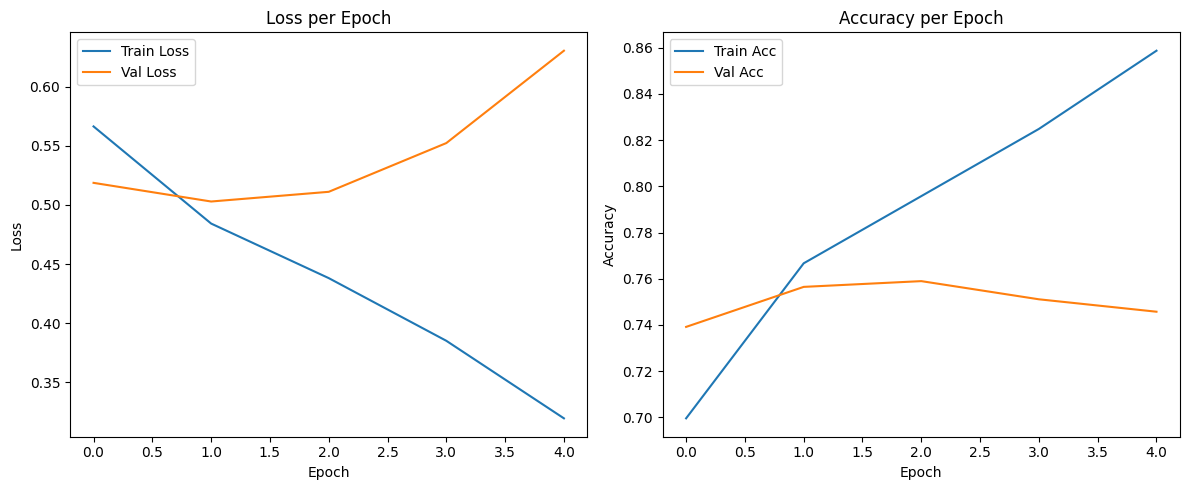


Example predictions:
Text: This movie was absolutely terrible. I hated every minute of it.
Sentiment: Negative (Score: 0.0465)
--------------------------------------------------
Text: I loved this product! It works exactly as described and the quality is amazing.
Sentiment: Positive (Score: 0.9385)
--------------------------------------------------
Text: The service was okay, nothing special but not bad either.
Sentiment: Negative (Score: 0.1545)
--------------------------------------------------


In [ ]:
if __name__ == "__main__":
    """
    Sentiment140 verisetiyle tam uçtan-uca eğitim/deneme örneği.
    - Veri kümesindeki 'sentiment' sütunu: 0 = negative, 4 = positive
    - run_sentiment_analysis() CSV dosyası beklediği için küçük bir alt-kümeyi
      pandas DataFrame'e dönüştürüp geçici CSV olarak kaydediyoruz.
    """
    from datasets import load_dataset
    import pandas as pd
    from sklearn.utils import shuffle
    import os

    print("Downloading Sentiment140 …")
    # Bu adım ilk çalıştırmada ~80 MB indirir ve birkaç saniye sürebilir
    ds = load_dataset("sentiment140", split="train")   # 1.6 M tweet

    # ▸ Opsiyonel: Daha hızlı deneme için 100 000 satırlık alt-kümeyle çalış
    #   Tamamını kullanmak istiyorsan next line'ı yorum satırı yap.
    ds = ds.shuffle(seed=42).select(range(100_000))

    # sentiment (0 or 4)  →  label (0 or 1)
    df = pd.DataFrame({
        "text": ds["text"],
        "label": [0 if s == 0 else 1 for s in ds["sentiment"]]
    })

    # Shuffle & save to a temporary CSV
    df = shuffle(df, random_state=42)
    csv_path = "sentiment140_binary.csv"
    df.to_csv(csv_path, index=False)

    # Train / evaluate the model
    model, vocab = run_sentiment_analysis(
        csv_path,
        n_epochs=5,        # Eğitimi istediğin gibi ayarlayabilirsin
        batch_size=64,
        max_words=10_000,  # En sık 10 000 kelime
        max_length=100
    )

    # Temizlik (istersen CSV'yi saklayabilirsin)
    os.remove(csv_path)
